<a href="https://colab.research.google.com/github/saerarawas/AAI614_rawas/blob/main/week7/Pandas-dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import glob

# Use glob to find all matching files
file_pattern = '/content/nyc-parking-tickets/*2017.csv'
files = glob.glob(file_pattern)

# Start timing
start_time = time.time()

# Load the dataset, handling inconsistent number of columns
df_list = []
for file in files:
    try:
        df = pd.read_csv(file)  # Attempt to read the file normally
        #df = pd.read_csv(file, dtype=dtype, na_values=['', 'NaN'], keep_default_na=True)
        df_list.append(df)
    except pd.errors.ParserError as e:
        print(f"Error reading file {file}: {e}")
        # Handle the error, e.g., skip the file or use 'on_bad_lines' parameter
        # Instead of skipping the file entirely, try to read it with error handling:
        df = pd.read_csv(file, on_bad_lines='skip')  # Skip problematic lines
        df_list.append(df) # Append the dataframe to the list even if it has errors

df_pandas = pd.concat(df_list, ignore_index=True)

# End timing
end_time = time.time()
print(f"Pandas Load Data - Wall Time: {end_time - start_time} seconds")

# Check the first few rows of the dataframe
print(df_pandas.head())

Pandas Load Data - Wall Time: 0.4284029006958008 seconds
   Summons Number Plate ID Registration State Plate Type  Issue Date  \
0      5092469481  GZH7067                 NY        PAS  07/10/2016   
1      5092451658  GZH7067                 NY        PAS  07/08/2016   
2      4006265037  FZX9232                 NY        PAS  08/23/2016   
3      8478629828  66623ME                 NY        COM  06/14/2017   
4      7868300310  37033JV                 NY        COM  11/21/2016   

   Violation Code Vehicle Body Type Vehicle Make Issuing Agency  Street Code1  \
0               7              SUBN        TOYOT              V             0   
1               7              SUBN        TOYOT              V             0   
2               5              SUBN         FORD              V             0   
3              47              REFG        MITSU              T         10610   
4              69              DELV        INTER              T         10510   

   ...  Vehicle Color  

In [13]:
# Start timing
start_time = time.time()

# Calculate missing values
missing_values = df_pandas.isnull().sum()

# Calculate percentage of missing values
missing_count_pct = (missing_values / len(df_pandas)) * 100

# End timing
end_time = time.time()
print(f"Pandas Calculate Missing Values - Wall Time: {end_time - start_time} seconds")



Pandas Calculate Missing Values - Wall Time: 0.07512187957763672 seconds


In [14]:
# Start timing
start_time = time.time()

# Identify columns to drop
columns_to_drop = missing_count_pct[missing_count_pct > 60].index

# Drop the columns
df_dropped_pandas = df_pandas.drop(columns=columns_to_drop)

# End timing
end_time = time.time()
print(f"Pandas Drop Columns - Wall Time: {end_time - start_time} seconds")



Pandas Drop Columns - Wall Time: 0.01567387580871582 seconds


   Summons Number Plate ID Registration State Plate Type  Issue Date  \
0      5092469481  GZH7067                 NY        PAS  07/10/2016   
1      5092451658  GZH7067                 NY        PAS  07/08/2016   
2      4006265037  FZX9232                 NY        PAS  08/23/2016   
3      8478629828  66623ME                 NY        COM  06/14/2017   
4      7868300310  37033JV                 NY        COM  11/21/2016   

   Violation Code Vehicle Body Type Vehicle Make Issuing Agency  Street Code1  \
0               7              SUBN        TOYOT              V             0   
1               7              SUBN        TOYOT              V             0   
2               5              SUBN         FORD              V             0   
3              47              REFG        MITSU              T         10610   
4              69              DELV        INTER              T         10510   

   ...  Law Section  Sub Division  Days Parking In Effect      \
0  ...       11

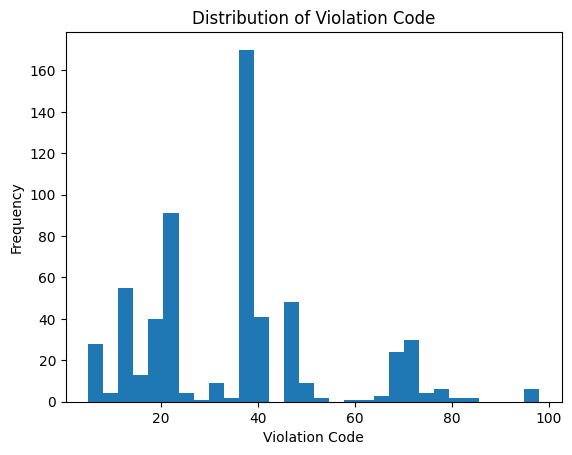

In [15]:
# Start timing
start_time = time.time()

# Display the first few rows
print(df_dropped_pandas.head())

# Calculate basic statistics
print(df_dropped_pandas.describe())

# End timing
end_time = time.time()
print(f"Pandas Basic Statistics - Wall Time: {end_time - start_time} seconds")

# Visualize distributions of key columns
df_sample = df_dropped_pandas.sample(frac=0.01)
# Convert 'Violation Code' to numeric, handling errors
df_sample['Violation Code'] = pd.to_numeric(df_sample['Violation Code'], errors='coerce')
# 'coerce' will replace non-numeric values with NaN
plt.hist(df_sample['Violation Code'], bins=30)
plt.title('Distribution of Violation Code')
plt.xlabel('Violation Code')
plt.ylabel('Frequency')
plt.show()


In [16]:
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import time
import glob
import matplotlib.pyplot as plt

# Use glob to find all matching files
file_pattern = '/content/nyc-parking-tickets/*2017.csv'
files = glob.glob(file_pattern)

# Define the data types for the problematic columns
dtype = {
    'Date First Observed': 'object',
    'Feet From Curb': 'object',
    'House Number': 'object',
    'Issuer Code': 'object',
    'Issuer Precinct': 'object',
    'Law Section': 'object',
    'Street Code1': 'object',
    'Street Code2': 'object',
    'Street Code3': 'object',
    'Summons Number': 'object',
    'Time First Observed': 'object',
    'Unregistered Vehicle?': 'object',
    'Vehicle Expiration Date': 'object',
    'Vehicle Year': 'object',
    'Violation Code': 'object',
    'Violation Location': 'object',
    'Violation Precinct': 'object'
}

# Preprocess with pandas to handle errors
def preprocess_csv(file):
    try:
        df = pd.read_csv(file, dtype=str, delimiter=",")
        # Handle potential row inconsistencies
        df = df.dropna(how="any")
        return df
    except Exception as e:
        print(f"Error processing {file}: {e}")
        return pd.DataFrame()

# Start timing for preprocessing
start_time = time.time()
df_list = [preprocess_csv(file) for file in files]

# Concatenate all preprocessed DataFrames
df_pandas = pd.concat(df_list, ignore_index=True)
end_time = time.time()
print(f"Pandas Preprocess Data - Wall Time: {end_time - start_time} seconds")

# Convert pandas DataFrame to Dask DataFrame
df_dask = dd.from_pandas(df_pandas, npartitions=10)

# Start timing for Dask operations
start_time = time.time()

# Calculate missing values
missing_values = df_dask.isnull().sum()

# Calculate percentage of missing values
missing_count_pct = (missing_values / df_dask.index.size) * 100

# Running Computations with the Compute Method
with ProgressBar():
    missing_count_pct = missing_count_pct.compute()

# End timing for Dask operations
end_time = time.time()
print(f"Dask Calculate Missing Values - Wall Time: {end_time - start_time} seconds")
print(missing_count_pct)



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Pandas Preprocess Data - Wall Time: 0.6193075180053711 seconds
[########################################] | 100% Completed | 108.93 ms
Dask Calculate Missing Values - Wall Time: 0.16118836402893066 seconds
Summons Number                      NaN
Plate ID                            NaN
Registration State                  NaN
Plate Type                          NaN
Issue Date                          NaN
Violation Code                      NaN
Vehicle Body Type                   NaN
Vehicle Make                        NaN
Issuing Agency                      NaN
Street Code1                        NaN
Street Code2                        NaN
Street Code3                        NaN
Vehicle Expiration Date             NaN
Violation Location                  NaN
Violation Precinct                  NaN
Issuer Precinct                     NaN
Issuer Code                         NaN
Issuer Command                      NaN
Issuer Squad                        NaN
Violation Time                    

In [17]:
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import time
import glob
import matplotlib.pyplot as plt

# Use glob to find all matching files
file_pattern = '/content/nyc-parking-tickets/*2017.csv'
files = glob.glob(file_pattern)

# Define the data types for the problematic columns
dtype = {
    'Date First Observed': 'object',
    'Feet From Curb': 'object',
    'House Number': 'object',
    'Issuer Code': 'object',
    'Issuer Precinct': 'object',
    'Law Section': 'object',
    'Street Code1': 'object',
    'Street Code2': 'object',
    'Street Code3': 'object',
    'Summons Number': 'object',
    'Time First Observed': 'object',
    'Unregistered Vehicle?': 'object',
    'Vehicle Expiration Date': 'object',
    'Vehicle Year': 'object',
    'Violation Code': 'object',
    'Violation Location': 'object',
    'Violation Precinct': 'object'
}

# Preprocess with pandas to handle errors
def preprocess_csv(file):
    try:
        df = pd.read_csv(file, dtype=dtype, delimiter=",", engine='python', error_bad_lines=False)
        # Handle potential row inconsistencies
        df = df.dropna(how="any")
        return df
    except Exception as e:
        print(f"Error processing {file}: {e}")
        return pd.DataFrame()

# Start timing for preprocessing
start_time = time.time()
df_list = [preprocess_csv(file) for file in files]

# Concatenate all preprocessed DataFrames
df_pandas = pd.concat(df_list, ignore_index=True)
end_time = time.time()
print(f"Pandas Preprocess Data - Wall Time: {end_time - start_time} seconds")

# Convert pandas DataFrame to Dask DataFrame
df_dask = dd.from_pandas(df_pandas, npartitions=10)

# Check the first few rows of the Dask DataFrame
print(df_dask.head())

# Start timing for Dask operations
start_time = time.time()

# Calculate missing values
missing_values = df_dask.isnull().sum()

# Calculate percentage of missing values
missing_count_pct = (missing_values / df_dask.index.size) * 100

# Running Computations with the Compute Method
with ProgressBar():
    missing_count_pct = missing_count_pct.compute()

# End timing for Dask operations
end_time = time.time()
print(f"Dask Calculate Missing Values - Wall Time: {end_time - start_time} seconds")
print(missing_count_pct)



Error processing /content/nyc-parking-tickets/Parking_Violations_Issued_-_Fiscal_Year_2017.csv: read_csv() got an unexpected keyword argument 'error_bad_lines'
Pandas Preprocess Data - Wall Time: 0.0017652511596679688 seconds
Empty DataFrame
Columns: []
Index: []
[########################################] | 100% Completed | 104.22 ms
Dask Calculate Missing Values - Wall Time: 0.11977028846740723 seconds
Series([], dtype: float64)
